[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/delta/blob/master/tutorial_notebooks/Tut6_RNN_for_Time_Series_Teacher.ipynb)

# Tutorial 6: RNNs for Time Series Forecasting

Among the various neural network architectures, **Recurrent Neural Networks (RNNs)** are specifically designed for sequential data—data ordered by time or event sequence. Unlike feedforward neural networks (FNNs), which process inputs independently, RNNs incorporate temporal structure by maintaining a hidden state that evolves over time. This allows RNNs to model dependencies between timesteps and capture temporal dynamics in tasks such as time series forecasting.

While FNNs typically ingest a fixed number of lagged inputs (e.g., $x_{t-3}, x_{t-2}, x_{t-1}$) without regard to order or spacing, RNNs use a recurrent structure:

$$
\quad y_t = W_{ho} h_t + b_o ~~~,\qquad h_t = \sigma(W_{ih} x_t + W_{hh} h_{t-1} + b_h)
$$

<br>
<img src="https://i.imgur.com/mHCNi1Q.png" width="900">
<br>
<br>

Here, $h_t$ is the hidden state at timestep $t$, updated based on the current input $x_t$ and the previous state $h_{t-1}$. The output $y_t$ can be interpreted as the forecast for time $t$, or further transformed to predict future values. Because the hidden state acts as a summary of all past inputs, the model captures dependencies over time without explicitly requiring lagged features.

RNNs are termed "recurrent" because information from the past (via the hidden state) is passed forward to influence future predictions. However, this recurrence is linear in time and does not involve self-loops within neurons. For a fixed-length sequence, an RNN can be "unfolded" and represented as a deep FNN, one layer per timestep—this insight enables **Backpropagation Through Time (BPTT)** to train the model.

### Stateful vs Stateless RNNs

In practical implementations, RNNs can be configured as either **stateless** or **stateful** depending on how they manage hidden states across sequence batches:

- **Stateless RNNs** reset the hidden state after processing each sequence (or batch). This is suitable when sequences are independent (e.g., daily samples across different cities). The model starts "fresh" for each sequence, ignoring any past context across batches.
  
- **Stateful RNNs** preserve the hidden state across batches. This allows the model to maintain continuity across timesteps that span multiple input windows. It is essential when forecasting long time series where dependencies stretch beyond the windowed input. However, careful alignment of sequence boundaries and batch indexing is required to avoid state leakage or misalignment.

Stateful RNNs can improve long-range learning but introduce complexity in training, especially with respect to sequence padding, batching, and hidden state management. During evaluation or inference, statefulness can be leveraged to roll the model forward sequentially, using previously computed hidden states for smoother, autoregressive predictions.

### Limitations of Vanilla RNNs

Despite their strengths, vanilla RNNs struggle to learn long-term dependencies. This is due to the **vanishing gradient problem**: as gradients are propagated backward through time, they shrink exponentially, making it difficult for the model to learn from distant past inputs (Bengio et al., 1994). In practice, this leads to poor performance on sequences with long-range temporal correlations.

<br>
<img src="https://i.imgur.com/4T0IoIu.png" width="900">
<br>
<br>

### Long Short-Term Memory (LSTM)

To address this, **Long Short-Term Memory (LSTM)** networks were introduced (Hochreiter & Schmidhuber, 1997). LSTMs augment the RNN with a **cell state** $c_t$ that serves as long-term memory, and three **gates** to regulate information flow:

- **Forget gate** decides what information to discard from the cell state.
- **Input gate** determines what new information to add.
- **Output gate** controls what part of the cell state is exposed to the hidden state.

<br>
<img src="https://i.imgur.com/CCphF2s.png" width="900">
<br>
<br>

The use of these gates allows LSTMs to retain relevant information over long sequences, mitigating the vanishing gradient problem. Importantly, the gates are differentiable (typically sigmoid-activated), allowing continuous, learnable control over the memory.

### Gated Recurrent Unit (GRU)

**Gated Recurrent Units (GRUs)** offer a simpler alternative to LSTMs (Cho et al., 2014). GRUs merge the cell and hidden states into a single vector and reduce the gating mechanism to just two gates:

- **Update gate** blends old and new information.
- **Reset gate** controls how much past information to forget.

<br>
<img src="https://i.imgur.com/sVqU42K.png" width="900">
<br>
<br>

Despite being computationally lighter and having fewer parameters than LSTMs, GRUs often perform comparably, especially in cases with limited data or computational resources (Graves, 2012).

In time series forecasting, RNNs, LSTMs, and GRUs are used to generate:

- **One-step forecasts**: Predict the next value $x_{t+1}$ from inputs up to $x_t$.
- **Multi-step forecasts**: Predict several future values, often by feeding predictions back into the model.

The hidden states can also be passed through feedforward layers for shape adaptation or forecasting tasks involving multiple variables.

In this notebook, you will:

1. Prepare time series data as sequences of input-output pairs.
2. Implement RNN, and LSTM, architectures using Keras.
4. Compare performance across architectures.

Pay attention to how architecture choices influence model capacity, training dynamics, and forecasting accuracy.


## Data Preparation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras

In [ ]:
# Simulate time series
time_window = np.arange(120)
ts = np.sin(time_window)**2 + 0.001*time_window

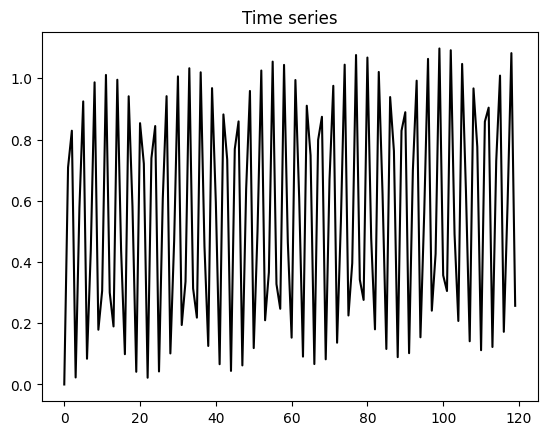

In [ ]:
# Plot time series
plt.plot(ts, color = 'black')
plt.title('Time series')
plt.show()
plt.close()

## Exercise 1: Data Transformation

Transform the time series data `ts` into a target 
$$y=\left(\begin{array}{cc} 
y_{1} \\
y_{2}  \\
\vdots  \\
y_{t-1} \\
y_{t} 
\end{array}\right)
$$ 
and a feature matrix (with only one column) 
$$X=\left(\begin{array}{cc} 
y_{0}\\
y_{1} \\
\vdots \\
y_{t-2}\\
y_{t-1}
\end{array}\right)
$$
<br>

Choose the first 80 observations as training data, the next 20 as validation and the remaining observations as test data. Use the function `create_dataset`, provided below.

In [136]:
## prepare data for model building
def create_dataset(time_series, window_size):
    """Function to create data set with lagged response values for estimating an autoregressive model"""
    dataX, dataY = [], []
    
    for i in range(0,len(time_series) - window_size):
        x = np.reshape(time_series[i:i + window_size],(-1,1)) # Remember: x[a:b-1]
        dataX.append(x)
        y = time_series[i + window_size] # Remember: x[b]
        dataY.append(y)
           
    return np.array(dataX), np.array(dataY)

## Create data set and split in training and test
X_matrix, y  = create_dataset(ts, 1)
# Training set
X_train = X_matrix[:80]
Y_train = y[:80]
# Validation set
X_val = X_matrix[80:100]
Y_val = y[80:100]
# Test set
X_test = X_matrix[100:]
Y_test = y[100:]

In [137]:
X_train.shape

(80, 1, 1)

In [138]:
X_val.shape

(20, 1, 1)

In [139]:
X_test.shape

(19, 1, 1)

In [140]:
ts[:6]

array([0.        , 0.70907342, 0.82882181, 0.02291486, 0.57675002,
       0.92453576])

In [141]:
X_train[:5]

array([[[0.        ]],

       [[0.70907342]],

       [[0.82882181]],

       [[0.02291486]],

       [[0.57675002]]])

In [142]:
Y_train[:5]

array([0.70907342, 0.82882181, 0.02291486, 0.57675002, 0.92453576])

## Exercise 2: FNN

Fit a feedforward network of your choice and make predictions on the training and test set. Plot the predictions in comparison to the time series `y`.

In [ ]:
# Create feedforward neural network
seq_len = X_train.shape[-2]  # the timestep, in our case is 1
num_features = X_train.shape[-1]  # in our case is also 1

# Using the functional API
inputs = keras.Input(shape=(seq_len, num_features))
x = keras.layers.Flatten()(inputs)  # flat the dims of timesteps and input features
x = keras.layers.Dense(5, activation="relu")(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 5)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16 (64.00 B)

 Trainable params: 16 (64.00 B)

 Non-trainable params: 0 (0.00 B)

In [144]:
# fit the model and make predictions for train and test sets
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mae'])

history = model.fit(
    X_train,
    Y_train,
    epochs=100,
    batch_size=1,
    validation_data=(X_val, Y_val),
    verbose=0)

# make predictions
pred_ff_train = model.predict(X_train)
pred_ff_test = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


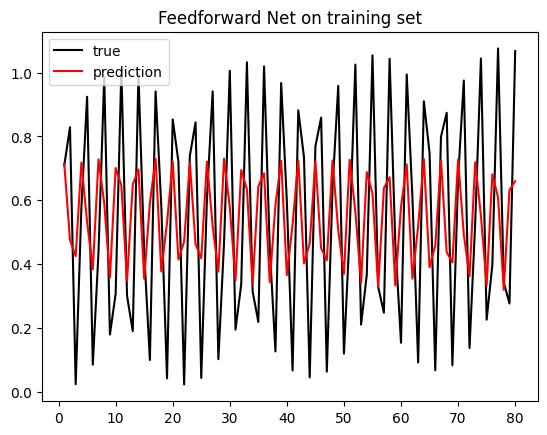

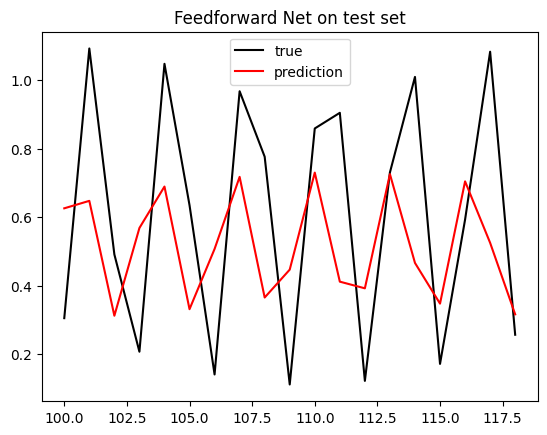

In [145]:
# Plot predictions on traning set
plt.plot(range(1, X_train.shape[0]+1), Y_train, color='black', label='true')
plt.plot(range(1, X_train.shape[0]+1),
         pred_ff_train, color='red', label='prediction')
plt.title('Feedforward Net on training set')
plt.legend()
plt.show()

# Plot predictions on test set
plt.plot(range(100, X_test.shape[0]+100), Y_test, color='black', label='true')
plt.plot(range(100, X_test.shape[0]+100),
         pred_ff_test, color='red', label='prediction')
plt.title('Feedforward Net on test set')
plt.legend()
plt.show()

## Exercise 3: Standard RNN

To avoid resetting the states by batches, we need to specify it with `stateful=True`.

In [ ]:
inputs = keras.Input(batch_shape=(1, seq_len, num_features))
x = keras.layers.SimpleRNN(5, stateful=True)(inputs)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (1, 1, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_12 (SimpleRNN)       │ (1, 5)                 │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (1, 1)                 │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

In [147]:
# fit the model and make predictions for train and test sets
model.compile(
    optimizer='rmsprop',
    loss='mse',
    metrics=['mae'],
)

model.fit(
    X_train,
    Y_train,
    epochs=100,
    batch_size=1,
    verbose=0,
    shuffle=False,
)

# make predictions
pred_srnn_train = model.predict(X_train, batch_size=1)
pred_srnn_test = model.predict(X_test, batch_size=1)

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step


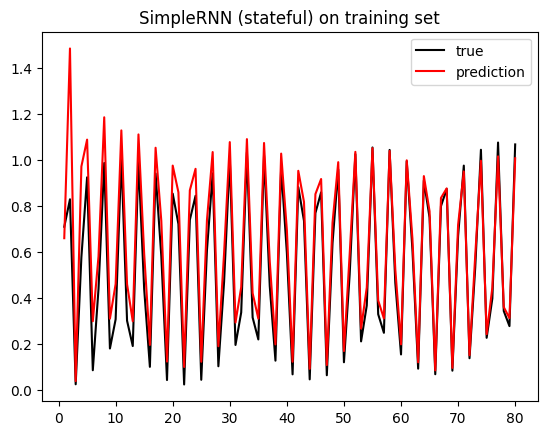

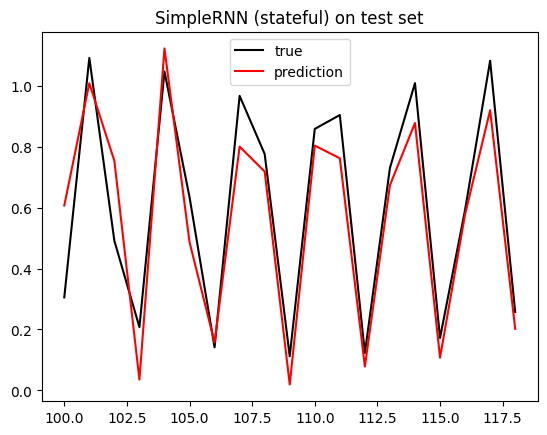

In [148]:
# Plot predictions on traning set
plt.plot(range(1, X_train.shape[0]+1), Y_train, color='black', label='true')
plt.plot(range(1, X_train.shape[0]+1),
         pred_srnn_train, color='red', label='prediction')
plt.title('SimpleRNN (stateful) on training set')
plt.legend()
plt.show()

# Plot predictions on test set
plt.plot(range(100, X_test.shape[0]+100), Y_test, color='black', label='true')
plt.plot(range(100, X_test.shape[0]+100),
         pred_srnn_test, color='red', label='prediction')
plt.title('SimpleRNN (stateful) on test set')
plt.legend()
plt.show()

Now fit an LSTM of your choice and plot its predictions on the training and test set against the true values `y`.

## Exercise 4: LSTM

In [ ]:
inputs = keras.Input(batch_shape=(1, seq_len, num_features))
x = keras.layers.LSTM(5, stateful=True)(inputs)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_27 (InputLayer)     │ (1, 1, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (1, 5)                 │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (1, 1)                 │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146 (584.00 B)

 Trainable params: 146 (584.00 B)

 Non-trainable params: 0 (0.00 B)

In [160]:
# fit the model and make predictions for train and test sets
model.compile(
    optimizer='rmsprop',
    loss='mse',
    metrics=['mae'],
)

# train stateful LSTM
model.fit(
    X_train,
    Y_train,
    epochs=100,
    batch_size=1,
    verbose=0,
    shuffle=False,
)

# make predictions
pred_lstm_train = model.predict(X_train, batch_size=1)
pred_lstm_test = model.predict(X_test, batch_size=1)

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step


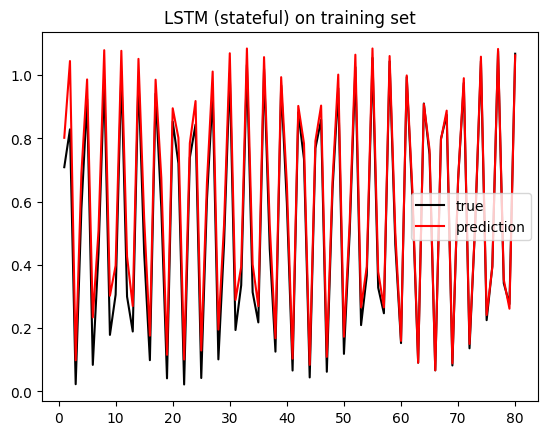

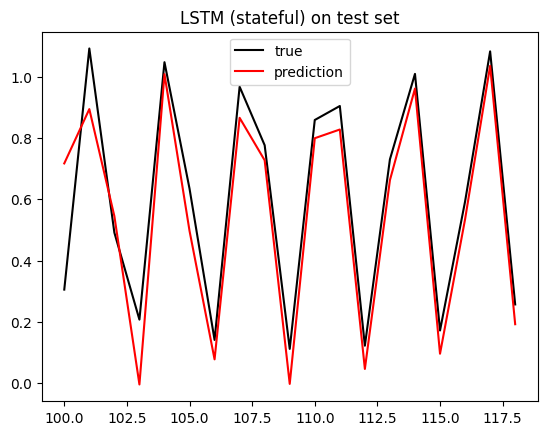

In [161]:
# Plot predictions on traning set
plt.plot(range(1, X_train.shape[0]+1), Y_train, color='black', label='true')
plt.plot(range(1, X_train.shape[0]+1),
         pred_lstm_train, color='red', label='prediction')
plt.title('LSTM (stateful) on training set')
plt.legend()
plt.show()

# Plot predictions on test set
plt.plot(range(100, X_test.shape[0]+100), Y_test, color='black', label='true')
plt.plot(range(100, X_test.shape[0]+100),
         pred_lstm_test, color='red', label='prediction')
plt.title('LSTM (stateful) on test set')
plt.legend()
plt.show()

## Remark

In this setting, the feedforward neural network cannot fully fit the time series. That is because this architecture only uses the past value $y_{t-1}$ to predict $y_{t}$. This is not sufficient, as $y_{t-1}$ does not contain the information of whether the curve is in an increasing or decreasing phase. Using more past information could be helpful. On the other hand, the LSTM fits the time series almost perfectly. This is due to the hidden states of the LSTM, which save information of the previous observations $y_{t-2},y_{t-3},...$ and can provide input as to whether the time series is increasing or decreasing at point $t-1$. 

## References

- Bengio, Y., Simard, P., & Frasconi, P. (1994). Learning long-term dependencies with gradient descent is difficult. *IEEE Transactions on Neural Networks*, 5(2), 157–166.  
- Hochreiter, S., & Schmidhuber, J. (1997). Long short-term memory. *Neural Computation*, 9(8), 1735–1780.  
- Gers, F. A., Schmidhuber, J., & Cummins, F. (2000). Learning to forget: Continual prediction with LSTM. *Neural Computation*, 12(10), 2451–2471.  
- Cho, K., van Merriënboer, B., Gulcehre, C., et al. (2014). Learning phrase representations using RNN encoder-decoder for statistical machine translation. *arXiv preprint arXiv:1406.1078*.  
- Graves, A. (2012). *Supervised Sequence Labelling with Recurrent Neural Networks*. Springer.  
- Goodfellow, I., Bengio, Y., & Courville, A. (2016). *Deep Learning*. MIT Press.